# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откроем файл с данными и изучим общую информацию. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
from collections import Counter
from pymystem3 import Mystem
m = Mystem()

In [2]:
flats = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
flats.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
7063,10,8200000.0,86.4,2016-04-28T00:00:00,3,3.01,9.0,48.2,2,NaN,False,False,11.9,2.0,Санкт-Петербург,7933.0,13174.0,1.0,667.0,0.0,NaN,71.0
2589,11,7150000.0,51.4,2019-03-09T00:00:00,2,NaN,11.0,31.0,3,NaN,False,False,8.4,NaN,Санкт-Петербург,35294.0,10352.0,1.0,434.0,1.0,502.0,NaN
2682,18,8000000.0,77.1,2016-03-20T00:00:00,2,NaN,9.0,42.0,8,NaN,False,False,13.0,2.0,Санкт-Петербург,33620.0,14006.0,0.0,NaN,1.0,47.0,729.0
20212,13,9980000.0,129.7,2017-07-11T00:00:00,3,2.85,14.0,80.5,3,NaN,False,False,19.8,2.0,Санкт-Петербург,30207.0,11072.0,1.0,313.0,1.0,1113.0,163.0
14030,0,4750000.0,43.0,2017-11-29T00:00:00,1,2.80,16.0,20.5,13,NaN,False,False,13.1,2.0,Санкт-Петербург,44881.0,17385.0,1.0,192.0,0.0,NaN,4.0


In [3]:
flats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [4]:
flats.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [5]:
flats.query('parks_around3000.isna()')[['ponds_nearest','parks_nearest','airports_nearest','ponds_around3000','cityCenters_nearest']].isna().sum()

ponds_nearest          5518
parks_nearest          5518
airports_nearest       5518
ponds_around3000       5518
cityCenters_nearest    5518
dtype: int64

Из таблицы выше видим, что это общий сбой автоматической выгрузки, на 5518 строк, лучше обратиться к отвественным за выгрузку.

### Вывод

Познакомились со структурой данных, обратили внимание на пропуски и типы данных.

Исследуем возможные причины появления пропусков:

Пользовательские данные:

- ceiling_height - 9195 пропусков, видимо, люди просто не знают высоту своих потолков и сочли это необязательной информацией
- floors_total - 86 пропусков, судя по количеству пропусков (очень мало), могли просто забыть указать
- living_area - 1903 пропуска, люди могут не знать что относить к жилой площади и сочли это необязательной информацией
- is_apartment - 20924 пропуска, очевидно, что люди просто оставляли поле пустым, указываю, что это не апартаменты
- kitchen_area - 2278 пропусков, люди могут не знать что относить к площади кухни и сочли это необязательной информацией
- balcony - 11519 пропусков, очевидно, что люди просто оставляли поле пустым, указываю, что это балконов нет
- locality_name - 49 пропусков, судя по количеству пропусков (очень мало), могли просто забыть указать
     
Картографические данные:

- Очевидно произошел сбой выгрузки автоматических данных, что повлекло за собой пропуски в 5518 строках в следующих 6 столбцах:
arports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest (таблица выше)
- отсавшиеся пропуски: parks_nearest, ponds_nearest и немного в cityCenters_nearest, airports_nearest - возможно, никакие объекты не входят в диапазон допустимых значений.




### Шаг 2. Предобработка данных

**Редактирование названия столбцов:**

Приведем названия к единому виду. 

In [6]:
flats.rename (columns={"total_images": "photo_q", "last_price": "price", "first_day_exposition": "date_pub",
                    "studio": "is_studio","open_plan": "is_open_plan",
                    "rooms": "rooms_q", "ceiling_height": "ceiling", "floors_total": "floors_q",
                    "balcony": "balcony_q", "locality_name": "place", "airports_nearest": "airports_dis",
                    "cityCenters_nearest": "center_dis", "parks_around3000": "parks_q", "parks_nearest": "parks_dis",
                    "ponds_around3000": "ponds_q", "ponds_around3000": "ponds_q", "ponds_nearest": "ponds_dis",
                    "days_exposition": "days_pub"}, inplace = True)

Проверяем, что все сработало корректно.

In [7]:
flats.isna().sum()

photo_q             0
price               0
total_area          0
date_pub            0
rooms_q             0
ceiling          9195
floors_q           86
living_area      1903
floor               0
is_apartment    20924
is_studio           0
is_open_plan        0
kitchen_area     2278
balcony_q       11519
place              49
airports_dis     5542
center_dis       5519
parks_q          5518
parks_dis       15620
ponds_q          5518
ponds_dis       14589
days_pub         3181
dtype: int64

Далее, исходя из запросов заказчика и поставленных задач, мы отбираем данные, которые нам необходимы для дальнейшей работы.

**Работа с пропусками**


Из списка столбцов с пропусками выше заполнять будем только те, которые нужны нам для поставленной задачи

Уберем из выборки студию и открытую планировку, так как их планировка сильно отличается от общей

In [8]:
flats_ap = flats.query('is_studio == False and is_open_plan == False')

Выберем параметр для заполнения living_area и kitchen_area, с которым у этих данных самая сильная корреляция

In [9]:
"{:.1%}".format(flats_ap['living_area'].corr(flats_ap['total_area']))

'93.9%'

Корреляция между илой площадью и общей - очень высокая - 94%, можем смело испольщовать эту зависимость для заполнения пропусков

In [10]:
living_k = flats_ap.query('living_area.notna()')['living_area'].sum() / flats_ap.query('living_area.notna()')['total_area'].sum()
living_k

0.572971842895114

Средняя доля жилой площади от общей - 0.57

Далее подберем самый подходящий параметр для площади кухни

In [11]:
"{:.1%}".format(flats_ap['kitchen_area'].corr(flats_ap['total_area']))

'60.9%'

Как видим, им оказалась снова общая площадь с корреляцией более 60%

In [12]:
kitchen_k = flats_ap.query('kitchen_area.notna()')['kitchen_area'].sum() / flats_ap.query('kitchen_area.notna()')['total_area'].sum()

In [13]:
kitchen_k

0.1739889261029742

Средняя доля площади кухни от общей - 0.174

Далее заполним пропуски в высотке потолков на основе мединных значений по количеству этажей в доме. Уберем выбивающиеся значения для расчета

In [14]:
flats_ceiling = flats.query('ceiling < 10 and ceiling > 1.7')

In [15]:
flats['floors_q'].fillna(value=-1, inplace=True)
flats['is_apartment'].fillna(value=0, inplace = True)
flats['balcony_q'].fillna(value=0, inplace = True)
flats['place'].fillna('неизвестно', inplace = True)
flats['ceiling'].fillna(value = flats_ceiling.groupby('floors_q')['ceiling'].transform('median'), inplace=True)
flats['ceiling'].fillna(value = flats_ceiling['ceiling'].median(), inplace=True)
flats['living_area'].fillna(value=living_k * flats['total_area'], inplace=True)
flats['kitchen_area'].fillna(value=kitchen_k* flats['total_area'], inplace=True)
flats['days_pub'].fillna(value=-1, inplace=True)
flats['center_dis'].fillna(value=-1000, inplace=True)

In [16]:
flats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
photo_q         23699 non-null int64
price           23699 non-null float64
total_area      23699 non-null float64
date_pub        23699 non-null object
rooms_q         23699 non-null int64
ceiling         23699 non-null float64
floors_q        23699 non-null float64
living_area     23699 non-null float64
floor           23699 non-null int64
is_apartment    23699 non-null object
is_studio       23699 non-null bool
is_open_plan    23699 non-null bool
kitchen_area    23699 non-null float64
balcony_q       23699 non-null float64
place           23699 non-null object
airports_dis    18157 non-null float64
center_dis      23699 non-null float64
parks_q         18181 non-null float64
parks_dis       8079 non-null float64
ponds_q         18181 non-null float64
ponds_dis       9110 non-null float64
days_pub        23699 non-null float64
dtypes: bool(2), float64(14), int64(3), object(3)


Все пропуски заполняем аномальными значениями, кроме тех данных, где пропуски очевидны (is_apartment) и (place)  заменяем на 'не известно'. По пропускам в данных, источником которых является автоматическая выгрузка, стоит задать вопросы отвественным лицам

In [17]:
flats.isna().sum()

photo_q             0
price               0
total_area          0
date_pub            0
rooms_q             0
ceiling             0
floors_q            0
living_area         0
floor               0
is_apartment        0
is_studio           0
is_open_plan        0
kitchen_area        0
balcony_q           0
place               0
airports_dis     5542
center_dis          0
parks_q          5518
parks_dis       15620
ponds_q          5518
ponds_dis       14589
days_pub            0
dtype: int64

**Изменение типов данных**

Для дискретных значений меняем тип данных на целые числа. Для формата дат и булевых типов - соотвествующие типы данных

In [18]:
flats = flats.assign(   
    floors_q = lambda x: x.floors_q.astype(int),
    days_pub = lambda x: x.days_pub.astype(int),
    date_pub = lambda x: pd.to_datetime(x.date_pub, format='%Y-%m-%dT%H:%M:%S'),
    is_apartment = lambda x: x.is_apartment.astype(bool),
       )

Проверяем 

In [19]:
flats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
photo_q         23699 non-null int64
price           23699 non-null float64
total_area      23699 non-null float64
date_pub        23699 non-null datetime64[ns]
rooms_q         23699 non-null int64
ceiling         23699 non-null float64
floors_q        23699 non-null int64
living_area     23699 non-null float64
floor           23699 non-null int64
is_apartment    23699 non-null bool
is_studio       23699 non-null bool
is_open_plan    23699 non-null bool
kitchen_area    23699 non-null float64
balcony_q       23699 non-null float64
place           23699 non-null object
airports_dis    18157 non-null float64
center_dis      23699 non-null float64
parks_q         18181 non-null float64
parks_dis       8079 non-null float64
ponds_q         18181 non-null float64
ponds_dis       9110 non-null float64
days_pub        23699 non-null int64
dtypes: bool(3), datetime64[ns](1), float64(12),

**Работа с дубликатами**

In [20]:
flats.duplicated().sum()

0

Дубликатов не найдено переходим к следующему шагу

**Вывод**

Вместо удаления строк с пустыми значениями - вставили аномальные значения (для упрощения дальнейшего анализа и тем самым не теряем значительную часть данных). В необходимых столбцах поправили форматы данных. Ненужные стобцы не удаляем - нет необходимости. Дупликатов в данных нет. Таблица готова для работы.

### Шаг 3. Посчитайте и добавьте в таблицу

Найдем среднюю цену за квадратный метр, день недели, месяц и год публикации и соотнешения жилой и площади кухни к общей площади. Сразу для дальнейших задач проведем категорзиацию данных по этажам.

In [21]:
flats = flats.assign(   
    avg_price = lambda x: (x.price / x.total_area),
    weekday_pub =lambda x: x.date_pub.dt.weekday,
    week_pub =lambda x: x.date_pub.dt.week,
    month_pub = lambda x: x.date_pub.dt.month,
    year_pub = lambda x: x.date_pub.dt.year,
    floor_cat = lambda x: np.where(x.floor == 1, "First", np.where(x.floor == x.floors_q, "Last", "Other")),
    living_part = lambda x: x.living_area / x.total_area,
    kitchen_part = lambda x: x.kitchen_area / x.total_area,
    )

Проверям, что столбцы были добавлены

In [22]:
flats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 30 columns):
photo_q         23699 non-null int64
price           23699 non-null float64
total_area      23699 non-null float64
date_pub        23699 non-null datetime64[ns]
rooms_q         23699 non-null int64
ceiling         23699 non-null float64
floors_q        23699 non-null int64
living_area     23699 non-null float64
floor           23699 non-null int64
is_apartment    23699 non-null bool
is_studio       23699 non-null bool
is_open_plan    23699 non-null bool
kitchen_area    23699 non-null float64
balcony_q       23699 non-null float64
place           23699 non-null object
airports_dis    18157 non-null float64
center_dis      23699 non-null float64
parks_q         18181 non-null float64
parks_dis       8079 non-null float64
ponds_q         18181 non-null float64
ponds_dis       9110 non-null float64
days_pub        23699 non-null int64
avg_price       23699 non-null float64
weekday_p

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

**Изучите следующие параметры: площадь, цена, число комнат, высота потолков. Постройте гистограммы для каждого параметра.**

In [23]:
flats[['total_area','avg_price','rooms_q','ceiling']].describe().round(2)

,total_area,avg_price,rooms_q,ceiling
count,23699.00,23699.00,23699.00,23699.00
mean,60.35,99421.66,2.07,2.72
std,35.65,50306.80,1.08,0.99
min,12.00,111.83,0.00,1.00
25%,40.00,76585.47,1.00,2.60
50%,52.00,95000.00,2.00,2.65
75%,69.90,114256.33,3.00,2.70
max,900.00,1907500.00,19.00,100.00


In [24]:
flats_plot = flats[['total_area','avg_price','rooms_q','ceiling']]

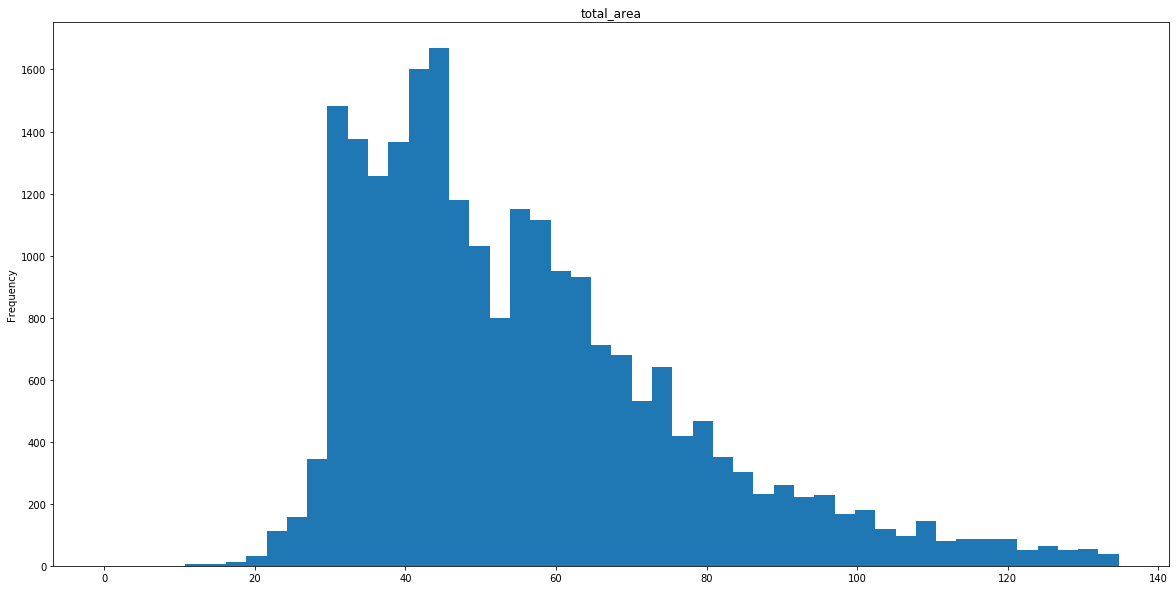

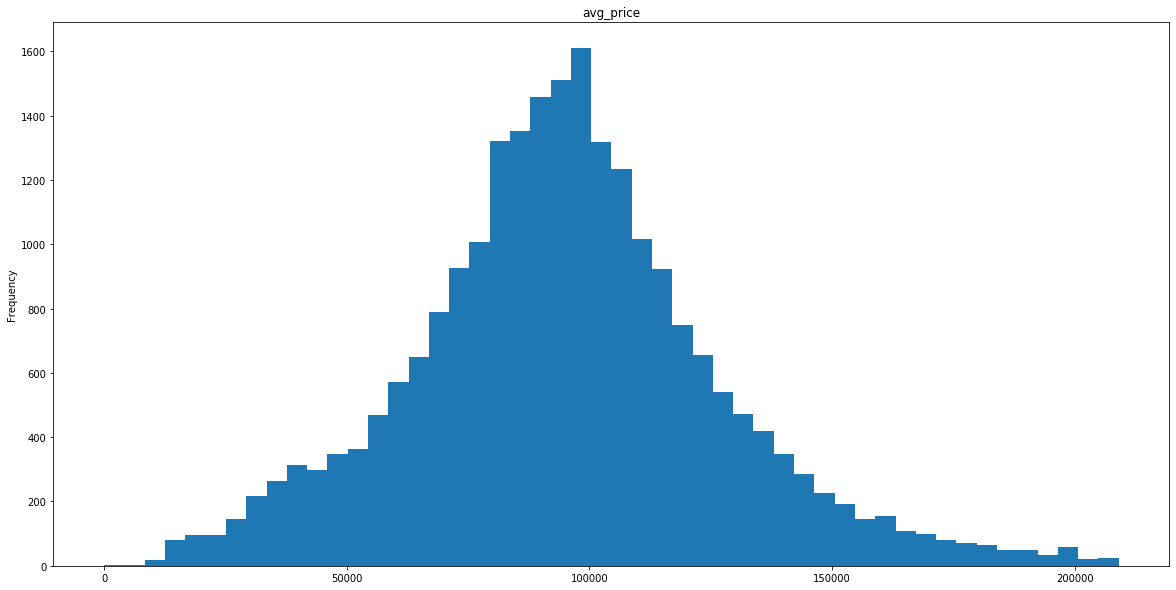

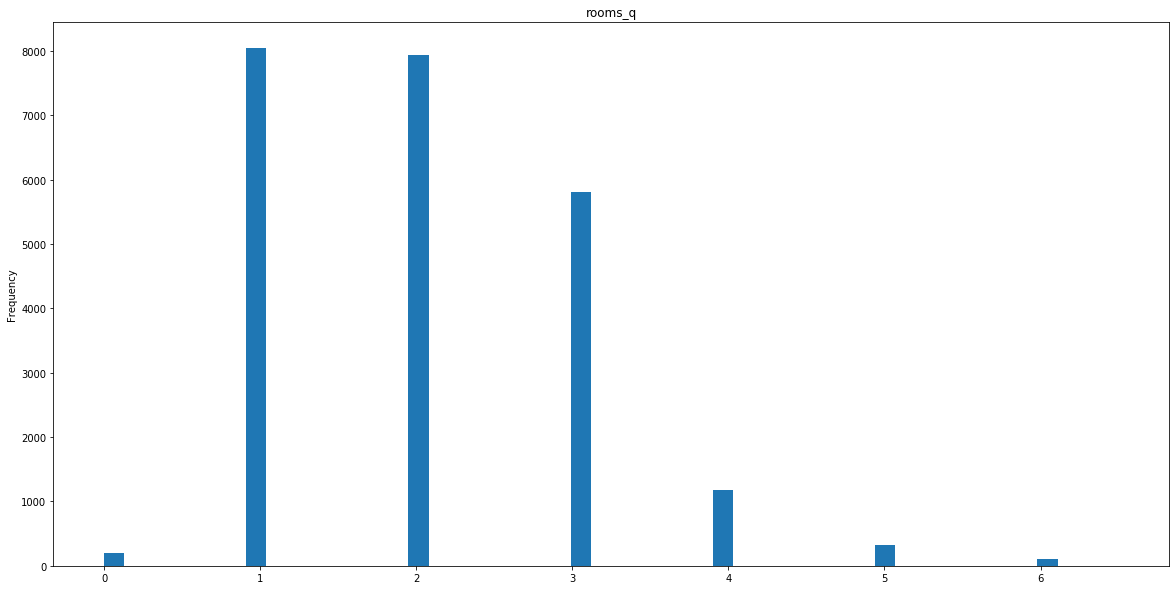

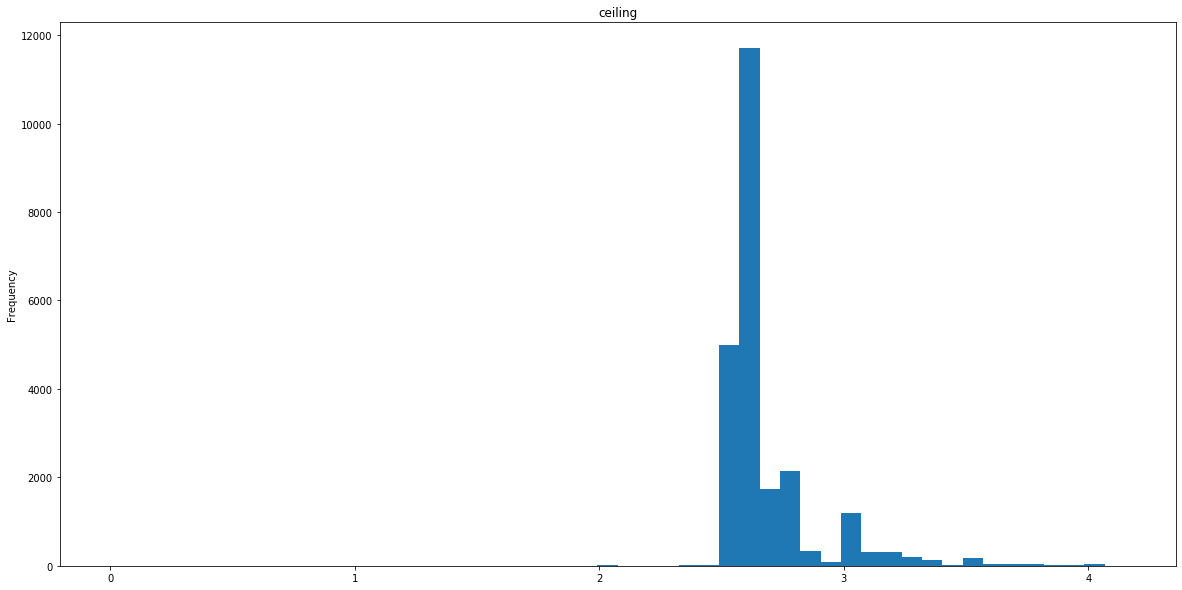

In [25]:
for name in flats_plot:
    a = flats_plot[name].quantile(0.75) + 1.5*flats_plot[name].quantile(0.75)-flats_plot[name].quantile(0.25)
    flats_plot[name].plot(range = (0,a), kind = 'hist', title= name, figsize = (20,10), bins = 50)
    plt.show()

In [26]:
flats[['total_area','avg_price','rooms_q','ceiling']].describe().round(2)

,total_area,avg_price,rooms_q,ceiling
count,23699.00,23699.00,23699.00,23699.00
mean,60.35,99421.66,2.07,2.72
std,35.65,50306.80,1.08,0.99
min,12.00,111.83,0.00,1.00
25%,40.00,76585.47,1.00,2.60
50%,52.00,95000.00,2.00,2.65
75%,69.90,114256.33,3.00,2.70
max,900.00,1907500.00,19.00,100.00


In [27]:
flats = flats.query('total_area >= 30 and total_area <= 140 and rooms_q >=1 and rooms_q <=6 and ceiling >= 2.5 and ceiling <= 3 and avg_price >=45000 and avg_price <=145000')

Цену убрал на основе стандартного отклонения

In [28]:
flats[['total_area','avg_price','rooms_q','ceiling']].describe().round(2)

,total_area,avg_price,rooms_q,ceiling
count,18312.00,18312.00,18312.00,18312.00
mean,54.80,93472.61,1.97,2.65
std,19.86,22220.11,0.90,0.11
min,30.00,45000.00,1.00,2.50
25%,40.00,78125.00,1.00,2.60
50%,50.00,93372.35,2.00,2.65
75%,65.00,108485.98,3.00,2.65
max,140.00,145000.00,6.00,3.00


Считаю, что фильтрация из анализа данных со свойством "апартаменты" не обязательна, так как для некоторых это является прямым аналогом квартиры, некоторые даже находят свои плюсы.

## Вывод

Среднее объявление:
 - Метраж квартиры 52 квадратных метра
 - Высота потолков 2,65 метра
 - Стоимость за квадратный метр  95 тыс.ед.
 - Количество комнат 2

**Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?**

In [29]:
days_pub_adj = flats.query('days_pub>0')

Анализируем только публикации, в которых есть дата (вообще, очень странно, что этих данных нет, наверняка, можно еще раз настойчиво попросить ответственных лиц выгрузить даты) 

In [30]:
days_pub_adj['days_pub'].describe().round(0)

count    16268.0
mean       173.0
std        212.0
min          1.0
25%         43.0
50%         92.0
75%        218.0
max       1580.0
Name: days_pub, dtype: float64

[Text(0, 0.5, 'Количество объявлений'),
 Text(0.5, 0, 'Количество дней'),
 Text(0.5, 1.0, 'Время публикации на сайте')]

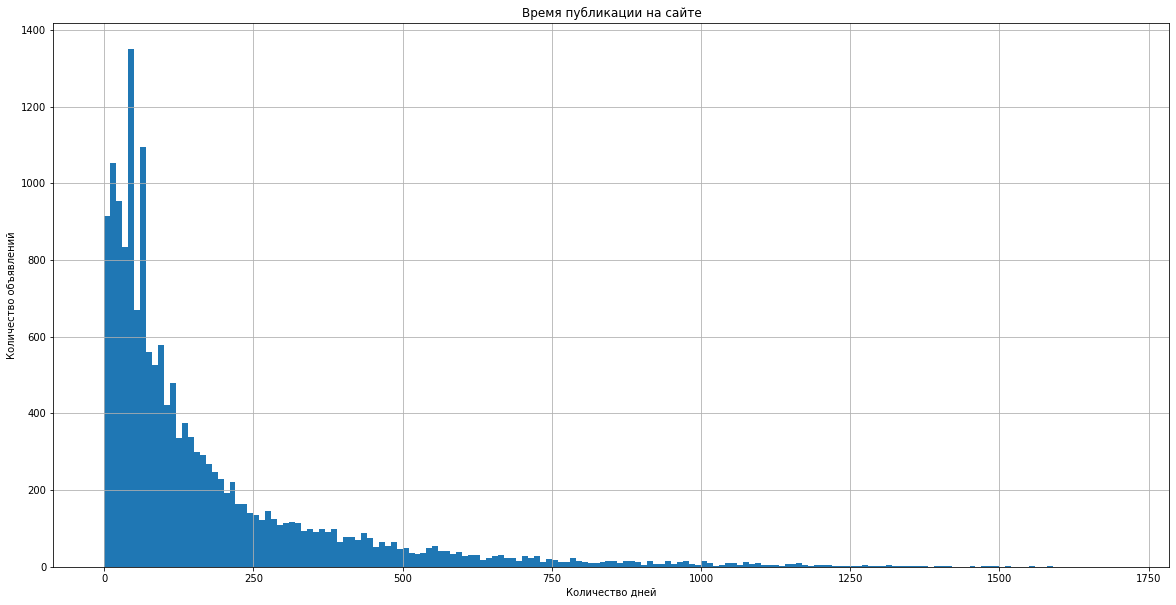

In [31]:
ax = days_pub_adj['days_pub'].hist(range = (0,1700), bins = 170, figsize = (20,10))
ax.set(title = 'Время публикации на сайте', xlabel =  "Количество дней", ylabel = 'Количество объявлений')

Находим среднюю и медиану времени публикации на сайте

In [32]:
print('Средняя: {:.0f}'.format(days_pub_adj['days_pub'].mean()),'день')
print('Медиана: {:.0f}'.format(days_pub_adj['days_pub'].median()),'дней')

Средняя: 173 день
Медиана: 92 дней


Для средней воспользуемся медианой, так как на графике можем наблюдать огромные выбросы

Определим пороги для необычно долгих и быстрых продаж. Если продажа заняла больше или меньше 90% процентов от общих значений, считаем ее необычной

In [33]:
print('Очень быстро - меньше {:.0f}'.format(days_pub_adj['days_pub'].quantile(0.1)),'дней')
print('Необычно долго - дольше {:.0f}'.format(days_pub_adj['days_pub'].quantile(0.9)),'дней')

Очень быстро - меньше 16 дней
Необычно долго - дольше 440 дней


## Вывод

В среднем публикация находится на сайте 86 дней, все публикации, что находятся на сайте меньше 16 дней или больше 418 дней - считаем необычными.

**Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили**

Уберем редкие значения (выбросы) которые не входят в межквартильный размах

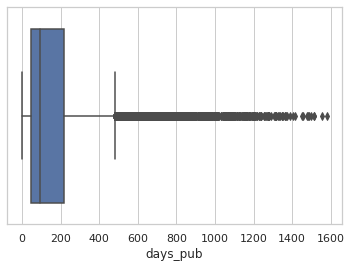

In [34]:
sns.set(style="whitegrid")
sns.boxplot('days_pub', data=days_pub_adj)

In [35]:
days_pub_adj['days_pub'].describe().round(2)

count    16268.00
mean       173.14
std        211.75
min          1.00
25%         43.00
50%         92.00
75%        218.00
max       1580.00
Name: days_pub, dtype: float64

[Text(0, 0.5, 'Количество объявлений'),
 Text(0.5, 0, 'Количество дней'),
 Text(0.5, 1.0, 'Время публикации на сайте')]

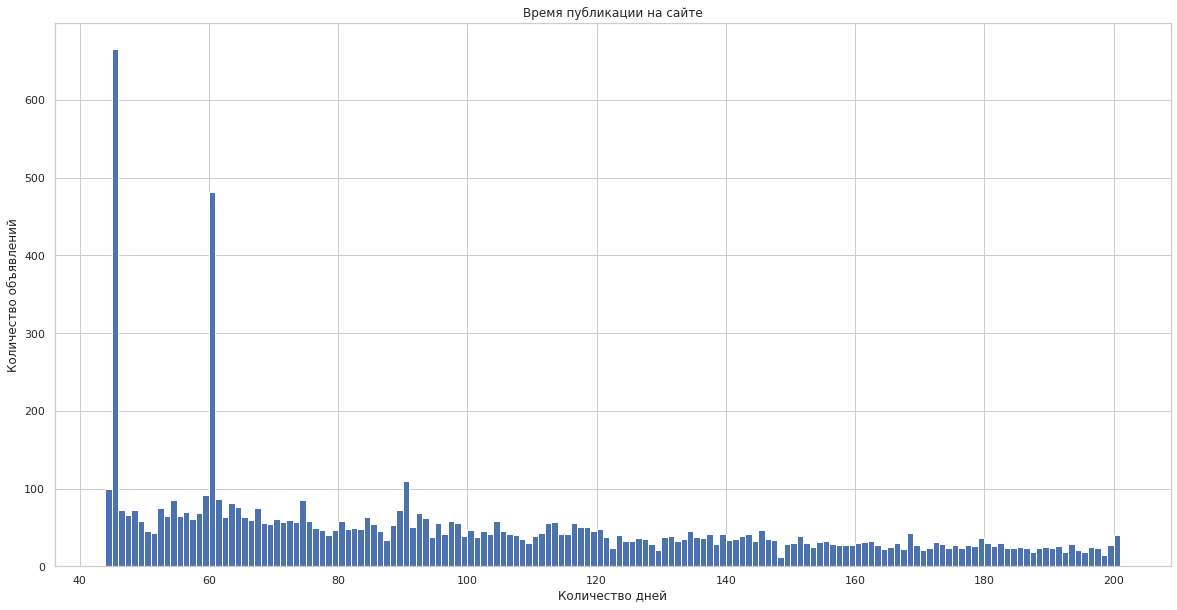

In [36]:
days_pub_adj2 = days_pub_adj.query('days_pub <=201 and days_pub >= 44')

ax = days_pub_adj2['days_pub'].hist(range = (44,201), bins = (201-44), figsize = (20,10))
ax.set(title = 'Время публикации на сайте', xlabel =  "Количество дней", ylabel = 'Количество объявлений')

На графике видим несколько выбивающихся значений, переходим к их анализу

In [37]:
days_pub_adj2['days_pub'].value_counts().sort_values(ascending = False).head(5)

45    666
60    482
90    110
44    100
59     92
Name: days_pub, dtype: int64

Похоже, на срок подачи объявления - неделя, месяц, полтора, два,три .... А это значит, что объявление сняли не по причине продажи, просто истек срок публикации. Очистим данные от этих артефактов и посмотрим, как после этого изменится среднее время публикации на сайте

Создадим список с исключениями

In [38]:
exceptions =[45,60]

days_pub_adj2.query('days_pub not in @exceptions')['days_pub'].median()

100.0

## Вывод

На среднее время продажи сильно повлияли выбросы и некорректные данные. После их очистки среднее время публикации на сайте увеличилось с 86 дней до 98 дней.

Во всех выводах пишу "среднее время публикации на сайте" вместо "среднее время продажи" умышленно, так как мы не можем быть уверены, что продажа состоялась, может быть просто обявление сняли

**Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от площади, числа комнат, удалённости от центра. Изучите зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Также изучите зависимость от даты размещения: дня недели, месяца и года.**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f177c454210>,
      dtype=object)

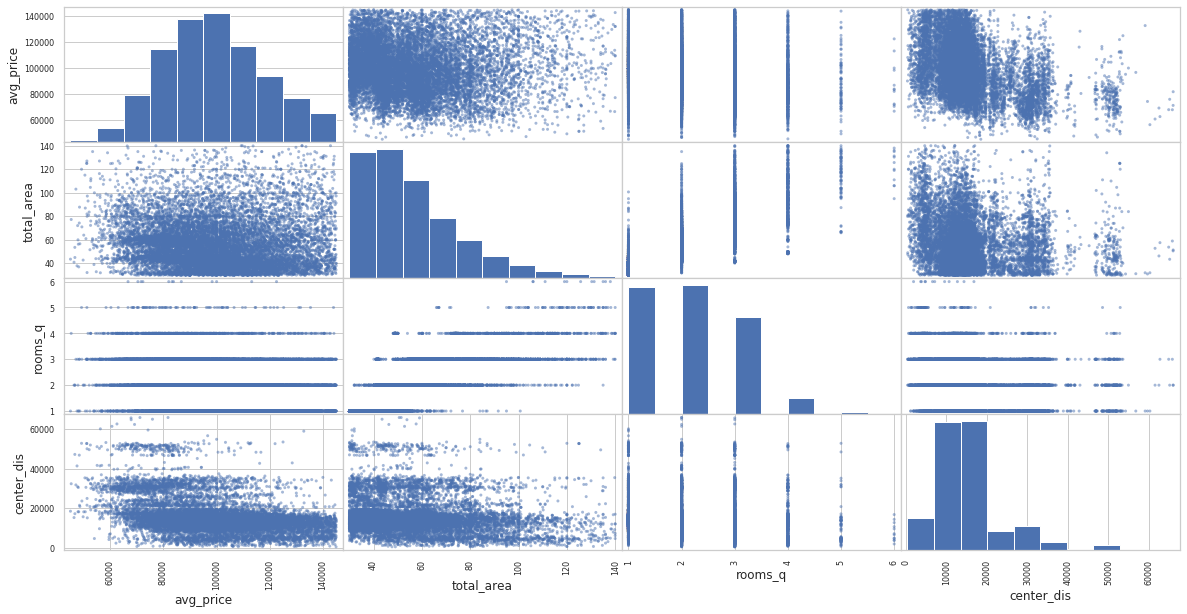

In [39]:
price_factor = flats.query('center_dis >=0 and rooms_q>0')
price_factor = price_factor[['avg_price','total_area','rooms_q','center_dis']]
pd.plotting.scatter_matrix(price_factor, figsize = (20,10))

 - На графиках справа видим зависимость от расстояния от центра, чем дальше от центра: меньше общая площадь, падает стоимость квадратного метра и среднее количество комнат тоже снижается. отрицательные значения в таблице корреляций показывают, что отрицательная зависимость слабая, но присутствует. 
 - Большинство обьявлений о продаже квартир, которые находятся около 15км от центра
 - Большинство квартир от 40 до 50 метров 

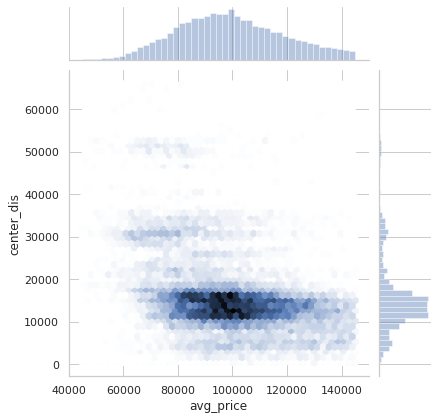

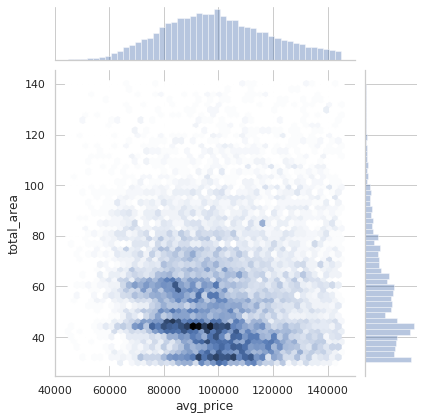

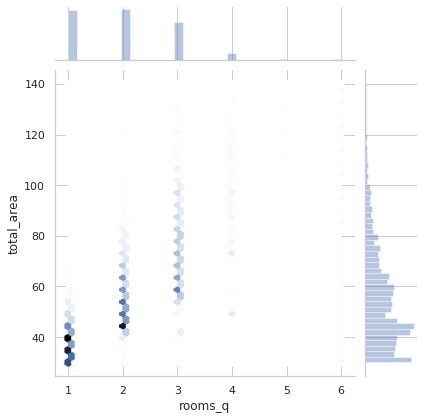

In [40]:
sns.jointplot(x='avg_price',y='center_dis',data=price_factor ,kind='hex')
sns.jointplot(x='avg_price',y='total_area',data=price_factor ,kind='hex')
sns.jointplot(x='rooms_q',y='total_area',data=price_factor ,kind='hex')

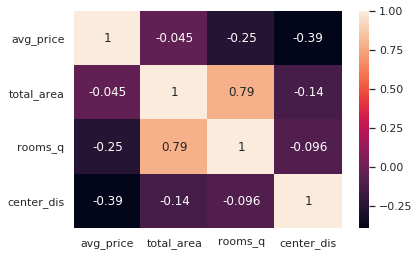

In [41]:
corr_heatmap = price_factor.corr()

sns.heatmap(corr_heatmap, annot = True)

**Изучите зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом**

In [42]:
flats.query('floors_q >=0').groupby('floor_cat')['avg_price'].median().round(0)

floor_cat
First    82989.0
Last     87892.0
Other    96037.0
Name: avg_price, dtype: float64

**Также изучите зависимость от даты размещения: дня недели, месяца и года**

[Text(0, 0.5, 'Цена за кв. м.'),
 Text(0.5, 0, 'День недели'),
 Text(0.5, 1.0, 'Цены по дням недели')]

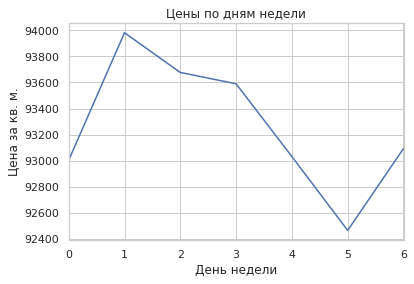

In [43]:
ax = flats.groupby('weekday_pub')['avg_price'].median().round(0).plot()
ax.set(title = 'Цены по дням недели', xlabel =  "День недели", ylabel = 'Цена за кв. м.')

[Text(0, 0.5, 'Цена за кв. м.'),
 Text(0.5, 0, 'Месяц'),
 Text(0.5, 1.0, 'Цены по месяцам')]

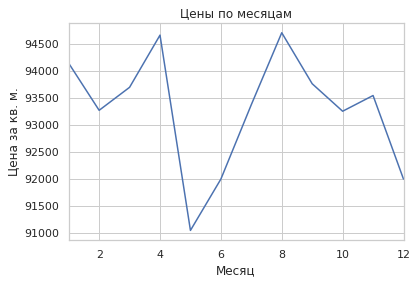

In [44]:
ax = flats.groupby('month_pub')['avg_price'].median().round(0).plot()
ax.set(title = 'Цены по месяцам', xlabel =  "Месяц", ylabel = 'Цена за кв. м.')

[Text(0, 0.5, 'Цена за кв. м.'),
 Text(0.5, 0, 'Год'),
 Text(0.5, 1.0, 'Цены по годам')]

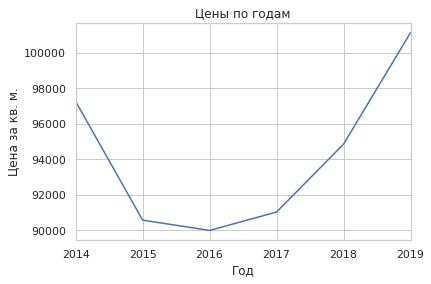

In [45]:
ax = flats.groupby('year_pub')['avg_price'].median().round(0).plot()
ax.set(title = 'Цены по годам', xlabel =  "Год", ylabel = 'Цена за кв. м.')

## Вывод

- Первый и последний этаж отрицательно влияют на стоимость квадратного метра, люди предпочитают им любой другой этаж 
- Объявления с самыми дорогим средним метров подаются в начале недели, в то время как на выходных - наоборот, самые дешевые, возможно это связано с тем, что владельцы дорогих квартир работают с агенствами, которые подают объвления за них
- Проседает стоимость квадратного метра в начале лета, возможно это связано с низкой активностью на рынке, всвязи с периодом отпусков и людям некогда заниматься этим
- Цена квадратного метра после 2014 года сильно просела и восстанавливается только после 2018 года, очевидно, что связано с кризисом 2014 года, (в конце 2014 года ЦБ сильно поднял ключевую ставку до 17%, что напрямую повлияло на ставки по ипотеке- это и привело к снижению спроса на недвижимость). На графике видим практически полное отражение ставок по ипотеке, чем меньше ставка, тем выше цена

**Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите среди них населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце 'locality_name'.**

In [46]:
places_list = []

for places in flats['place'].unique():
    for word in places.split():
        lemmas = ' '.join(m.lemmatize(word))
        places_list.append(lemmas)
              
Counter(places_list)

Counter({'санкт-петербург \n': 1,
         'поселок \n': 103,
         'шушар \n': 1,
         'городской \n': 37,
         'янино - 1 \n': 2,
         'парголовый \n': 1,
         'муриный \n': 3,
         'ломоносов \n': 1,
         'сертолово \n': 1,
         'петергоф \n': 1,
         'пушкин \n': 1,
         'деревня \n': 49,
         'кудрово \n': 2,
         'коммунар \n': 1,
         'колпино \n': 1,
         'гатчина \n': 1,
         'федоровский \n': 2,
         'выборг \n': 1,
         'кронштадт \n': 1,
         'кировск \n': 1,
         'новое \n': 1,
         'девяткино \n': 1,
         'металлострой \n': 1,
         'тип \n': 28,
         'лебяжий \n': 2,
         'кузьмоловский \n': 2,
         'садовый \n': 1,
         'товарищество \n': 1,
         'новый \n': 5,
         'ропша \n': 1,
         'павловск \n': 1,
         'пикколово \n': 1,
         'всеволожск \n': 1,
         'кингисепп \n': 1,
         'приозерск \n': 1,
         'куттузить \n': 1,
         'сестро

Находим наиболее часто повторяющиеся значения и формируем из них список приставок, который следует удалить (поселок,городской,тип,станция,деревня,село). Не будем применять лемматизацию, так как лемматизация исказит оригинальные названия населенных пунктов. Мы просто сотрем наиболее распространенные приставки. Для этого сначала приведем все названия к нижнему регистру

In [47]:
flats['place'] = flats['place'].str.lower()
flats['place'] = flats['place'].str.replace('посёлок ', '').str.replace('поселок ', '').str.replace('село ', '').str.replace('типа ', '').str.replace('станция ', '').str.replace('городского ', '').str.replace('деревня ', '').str.replace('имени ', '')

Удаляем именно в таком порядке, так как слово "село" содержится в слове "поселок". Не забываем убирать пробелы после слов

In [48]:
flats['place'].sample(20)

15897             пушкин
20666    санкт-петербург
1873             колтуши
19185    санкт-петербург
11431    санкт-петербург
7914     санкт-петербург
12068    санкт-петербург
20805    санкт-петербург
3452          новый свет
21742    санкт-петербург
14041    санкт-петербург
11454    санкт-петербург
17647    санкт-петербург
441      санкт-петербург
9435     санкт-петербург
20481    александровская
10840    санкт-петербург
20480    санкт-петербург
22851    санкт-петербург
4195     санкт-петербург
Name: place, dtype: object

Проверяем, что все сработало корректно

Выберем 10 населённых пунктов с наибольшим числом объявлений

In [49]:
top = flats.groupby('place')['price'].count().sort_values(ascending = False).head(10).reset_index()
top

,place,price
0,санкт-петербург,12243
1,мурино,510
2,кудрово,424
3,шушары,423
4,всеволожск,371
5,пушкин,320
6,колпино,320
7,парголово,317
8,гатчина,289
9,петергоф,187


In [50]:
"{:.1%}".format(flats.query('place == "санкт-петербург"')['place'].count() / flats['place'].count())

'66.9%'

In [51]:
"{:.1%}".format(flats.query('place == "мурино"')['place'].count() / flats['place'].count())

'2.8%'

Доля обьявлений в Санкт-Петербурге составляет 66.3 %, в то время, как ближайший приследователь Мурино - только 2,5%

In [52]:
top_pub = top['price'].sum()

Для подсчета средней цены квадратного метра в этих населённых пунктах создаем список из этих городов

In [53]:
top.drop('price', axis = 1, inplace = True)

Присоеденим к этому списку данные с ценой из основной таблицы

In [54]:
pivot_top = top.merge(flats, how = 'left')

pivot_top_median = pivot_top.groupby('place')['avg_price'].median().sort_values(ascending = False).reset_index().round(0)
pivot_top_median

,place,avg_price
0,санкт-петербург,100730.0
1,пушкин,98133.0
2,кудрово,94657.0
3,парголово,91643.0
4,мурино,83333.0
5,петергоф,81818.0
6,шушары,75949.0
7,колпино,74563.0
8,гатчина,67927.0
9,всеволожск,65833.0


Далее выделим населенные пункты с самой высокой и низкой ценой за квадратный метр

In [55]:
pivot_top_median.head(1).round(0)

,place,avg_price
0,санкт-петербург,100730.0


In [56]:
pivot_top_median.tail(1).round(0)

,place,avg_price
9,всеволожск,65833.0


In [57]:
"{:.1%}".format(top_pub/len(flats['place']))

'84.1%'

In [58]:
"{:.1%}".format(len(top)/flats['place'].nunique())

'6.0%'

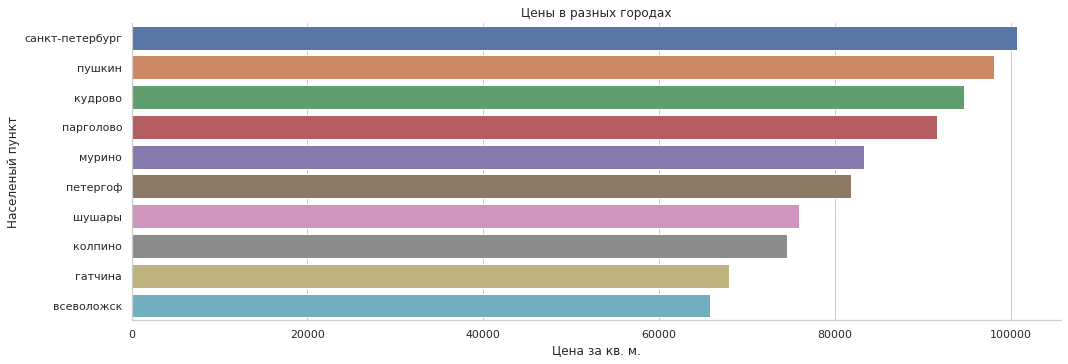

In [59]:
ax = sns.catplot(y='place',x='avg_price', data=pivot_top_median, kind='bar', aspect = 3)
ax.set(title = 'Цены в разных городах', xlabel =  "Цена за кв. м.", ylabel = 'Населеный пункт')

## Вывод 

Всего 3% городов (10 из 320) городов занимают долю более 66% в публикациях 
 - Самым дорогим городом для покупки квартиры является - Санкт-Петербур со средней ценой ок. 100 тыс. руб. за квадратный метр
 - Самым дешевым городом - Выборг - со средней ценой 66 тыс. руб. за квадратный метр

Можно сделать вывод, что сервис Яндекс.Недвижимость не развит в остальных 310 регионах, возможно, стоит подумать о дальнейшем развитии .  

**Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге ('locality_name'). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона.**

Создаем столбец с расстоянием до центра в километрах

In [60]:
flats['center_dis_km'] = (flats['center_dis']/1000).round(0)

Оставляем данные только по Санкт-Петербургу

[Text(0, 0.5, 'Цена за кв. м.'),
 Text(0.5, 0, 'Расстояние от центра'),
 Text(0.5, 1.0, 'Взаимосвязь цены от расстояния')]

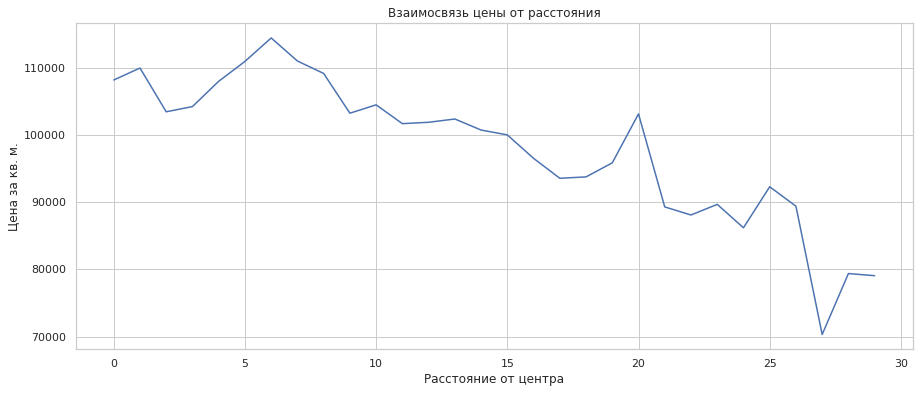

In [61]:
spb = flats.query('place == "санкт-петербург" and center_dis_km >=0')
spb_plot = spb.groupby('center_dis_km')['avg_price'].median().reset_index()

plt.figure(figsize=(15, 6))
ax = sns.lineplot(x="center_dis_km", y="avg_price", data=spb_plot)
ax.set(title = 'Взаимосвязь цены от расстояния', xlabel =  "Расстояние от центра", ylabel = 'Цена за кв. м.')

In [62]:
spb['center_dis_km'].corr(spb['total_area'])

-0.21666961850809716

## Вывод

На графике видим, что недвижимость как в Санкт-Петербурге, так и в целом по региону, после 8го километра имеет тенденцию к снижению цены за кв. метр, отсюда делаем вывод, что все что находится до 8км включительно - относится к центральной зоне. 
Видим еще одно "дно" на расстоянии 3км - видимо - это зона, где заканчивается старый город и начинаются новостройки

**Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?**

Проанализируем территорию до 8 км

In [63]:
spb_cen = spb.query('center_dis_km<=8')
spb_cen['center_dis_km'].value_counts()

5.0    365
8.0    365
4.0    295
6.0    281
7.0    223
3.0    154
2.0    104
1.0     66
0.0      3
Name: center_dis_km, dtype: int64

Так как объявлений в самом цетре всего 3!! удалим их из данных тоже

In [64]:
spb_cen = spb_cen.query('center_dis_km >0')
spb_cen['total_area'].describe()

count    1853.000000
mean       69.967679
std        24.923389
min        30.000000
25%        50.000000
50%        67.000000
75%        86.600000
max       140.000000
Name: total_area, dtype: float64

[Text(0, 0.5, 'Общая площадь'),
 Text(0.5, 0, 'Расстояние от центра'),
 Text(0.5, 1.0, 'Взаимосвязь общей площади от расстояния')]

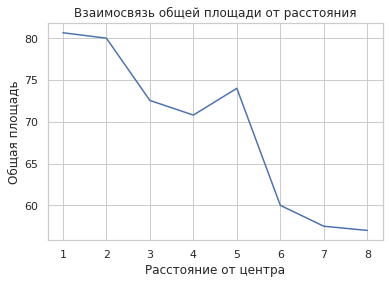

In [65]:
plot = spb_cen.groupby('center_dis_km')['total_area'].median().reset_index()

ax = sns.lineplot(x="center_dis_km", y="total_area", data=plot)
ax.set(title = 'Взаимосвязь общей площади от расстояния', xlabel =  "Расстояние от центра", ylabel = 'Общая площадь')

In [66]:
spb_cen['center_dis_km'].corr(spb_cen['total_area'])

-0.2560971939408889

На графике видим как уменьшается общая площадь квартир в зависимости от удаленности от центра. Видимо это связано с тем, что в центре больше старых зданий с бОльшим количеством комнат, а следовательно и общей площадью. 

Яркая демонстрация гипотезы, о близости старых зданий к центру https://how-old-is-this.house/

[Text(0, 0.5, 'Цена за кв. м.'),
 Text(0.5, 0, 'Расстояние от центра'),
 Text(0.5, 1.0, 'Взаимосвязь цены от расстояния')]

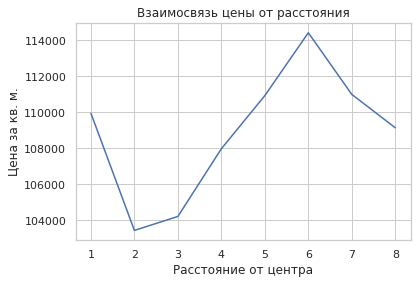

In [67]:
plot1 = spb_cen.groupby('center_dis_km')['avg_price'].median().reset_index()

ax = sns.lineplot(x="center_dis_km", y="avg_price", data=plot1)
ax.set(title = 'Взаимосвязь цены от расстояния', xlabel =  "Расстояние от центра", ylabel = 'Цена за кв. м.')

In [68]:
spb_cen['avg_price'].corr(spb_cen['center_dis_km'])

0.05307553301809239

Видим резкое падение в районе 3 км. Попробуем проверить данные на сильные выбросы с низкой ценой.

[Text(0, 0.5, 'Количество объявлений'),
 Text(0.5, 0, 'Цена за кв. м.'),
 Text(0.5, 1.0, 'Квартиры в 3км от центра')]

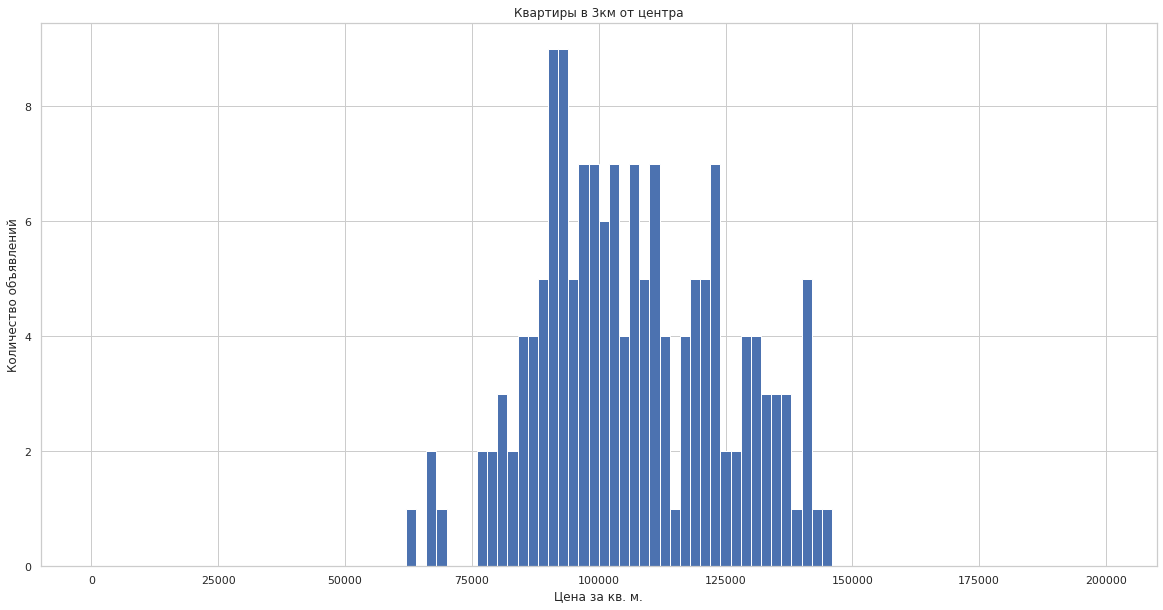

In [69]:
ax = spb_cen.query('center_dis_km == 3')['avg_price'].hist(range = (0,200000), bins = 100, figsize  = (20,10))
ax.set(title = 'Квартиры в 3км от центра', xlabel =  "Цена за кв. м.", ylabel = 'Количество объявлений')

Как видим, проблем с данными нет, видимо низкая цена связана с географическими особенностями, исследовав карту, можем сделать вывод, что в радиусе много вокзалов и идет обводной канал, возможно наличие промзон - все это может пагубно отражаться на стоимости.

Еще, возможно, повлияла реконструкция зданий в центре Санкт-Петербурга к 300 летию, возможно она не дошла только до 3го километра. Вот и получается, что за 3м километром есть новые здания и они дороже, чем старые неотреставрированые, но ближе к центру

[Text(0, 0.5, 'Количество комнат'),
 Text(0.5, 0, 'Расстояние от центра'),
 Text(0.5, 1.0, 'Взаимосвязь количества комнат от расстояния')]

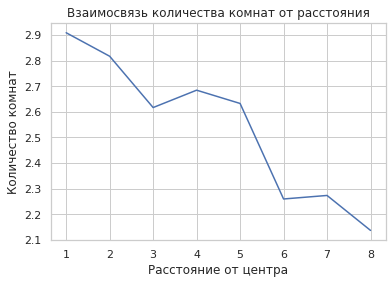

In [70]:
plot2 = spb_cen.groupby('center_dis_km')['rooms_q'].mean().reset_index()

ax = sns.lineplot(x="center_dis_km", y="rooms_q", data=plot2)
ax.set(title = 'Взаимосвязь количества комнат от расстояния', xlabel =  "Расстояние от центра", ylabel = 'Количество комнат')

In [71]:
spb['rooms_q'].corr(spb['center_dis_km'])

-0.17867100571059605

Так как количество возможных вариантов количества комнат мало, используем среднюю для большей информативности. Очевидно, что тоже связано с близостью старых зданий к центру.

[Text(0, 0.5, 'Высота потолков'),
 Text(0.5, 0, 'Расстояние от центра'),
 Text(0.5, 1.0, 'Взаимосвязь высоты потолков от расстояния')]

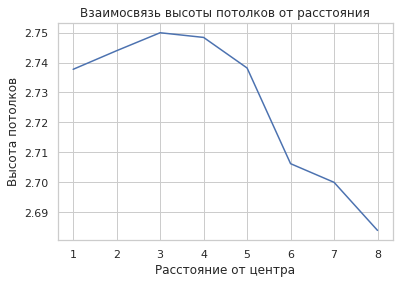

In [72]:
plot3 = spb_cen.query('ceiling > 0').groupby('center_dis_km')['ceiling'].mean().reset_index()

ax = sns.lineplot(x="center_dis_km", y="ceiling", data=plot3)
ax.set(title = 'Взаимосвязь высоты потолков от расстояния', xlabel =  "Расстояние от центра", ylabel = 'Высота потолков')

In [73]:
spb['ceiling'].corr(spb['center_dis_km'])

-0.21065261724560772

Не забудем убрать аномальные значения, которыми мы заполнили пропуски в высоте потолков. Как видим: высота потолков тоже напряму связана со старыми зданиями в центре

**Выделим факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления) и посмотрим, отличаются ли они от общих выводов по всему городу?**

Проанализируем влияние количества комнат на среднюю цену за квадратный метр

In [74]:
spb_cen['rooms_q'].value_counts()

2    686
3    627
1    301
4    193
5     39
6      7
Name: rooms_q, dtype: int64

Видно, что объявления с количеством комнат больше 6 встречаются довольно редко, для дальнейшего анализа отфильтруем их

[Text(0, 0.5, 'Цена за кв. м.'),
 Text(0.5, 0, 'Количество комнат'),
 Text(0.5, 1.0, 'Взаимосвязь цены за кв.м. от количества комнат (Центр)')]

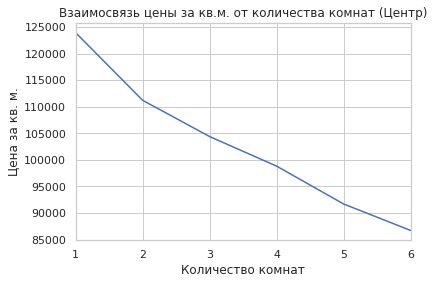

In [75]:
ax = spb_cen.query('rooms_q >=1 and rooms_q <=6').groupby('rooms_q')['avg_price'].median().plot(grid = True)
ax.set(title = 'Взаимосвязь цены за кв.м. от количества комнат (Центр)', xlabel =  "Количество комнат", ylabel = 'Цена за кв. м.')

Как видим, средняя цена за квадратный метр в центре имеет  отрицательную корреляцию с количеством комнат. Что, в целом логично (берешь больше - платишь меньше) 

[Text(0, 0.5, 'Цена за кв. м.'),
 Text(0.5, 0, 'Количество комнат'),
 Text(0.5, 1.0, 'Взаимосвязь цены за кв.м. от количества комнат (Весь город)')]

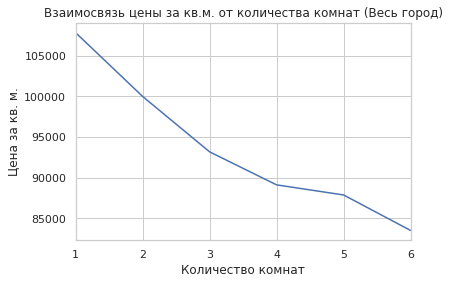

In [76]:
ax = spb.query('rooms_q >=1 and rooms_q <=6').groupby('rooms_q')['avg_price'].median().plot()
ax.set(title = 'Взаимосвязь цены за кв.м. от количества комнат (Весь город)', xlabel =  "Количество комнат", ylabel = 'Цена за кв. м.')

[Text(0, 0.5, 'Цена за кв. м.'),
 Text(0.5, 0, 'Количество комнат'),
 Text(0.5, 1.0, 'Взаимосвязь цены за кв.м. от количества комнат (Сравнение)')]

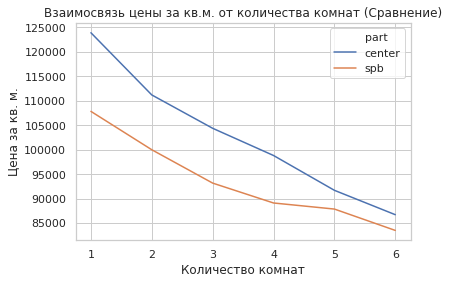

In [77]:
plot_comp_cen0 = spb_cen.query('rooms_q>=1 and rooms_q <=6').groupby('rooms_q')['avg_price'].median().round().reset_index()
plot_comp_cen0['part'] = 'center'
plot_comp_cen0.set_axis(['rooms_q','price','part'], axis = 'columns', inplace = True)

plot_comp_spb0 = spb.query('rooms_q>=1 and rooms_q <=6').groupby('rooms_q')['avg_price'].median().round().reset_index()
plot_comp_spb0['part'] = 'spb'
plot_comp_spb0.set_axis(['rooms_q','price','part'], axis = 'columns', inplace = True)

pivot_comp0 = pd.concat([plot_comp_cen0,plot_comp_spb0], ignore_index=False)

ax = sns.lineplot(x="rooms_q", y = 'price',  data=pivot_comp0, hue="part")
ax.set(title = 'Взаимосвязь цены за кв.м. от количества комнат (Сравнение)', xlabel =  "Количество комнат", ylabel = 'Цена за кв. м.')

Сравним корреляции по центру и всему городу (влияние количества комнат на стоимость)

In [78]:
display(spb_cen['rooms_q'].corr(spb_cen['avg_price']).round(3))
print('--vs--')
display(spb['rooms_q'].corr(spb['avg_price']).round(3))

-0.318

--vs--


-0.291

Но это правило не распространяется на весь город, видимо, новое жилье имеет лучшую планировку, возможно, это какие-то таун-хаусы, загородные дома и т.п., так как они помимо жилой площади имеют гаражи, сады или придомовые территории, которые имеют свою добавочную стоимость

Посмотрим, как влияет категория этажа на цену

In [79]:
floor_cen = spb_cen.groupby('floor_cat')['avg_price'].median().astype(int).reset_index()
floor_cen.set_axis(['floor','price (cen)'], axis = 'columns', inplace = True)

floor_spb = spb.groupby('floor_cat')['avg_price'].median().astype(int).reset_index()
floor_spb.set_axis(['floor','price (spb)'], axis = 'columns', inplace = True)

floor_comp = floor_cen.merge(floor_spb, how = 'left')
floor_comp['%'] = floor_comp['price (cen)'] / floor_comp['price (spb)'] 
floor_comp

,floor,price (cen),price (spb),%
0,First,100877,90651,1.112806
1,Last,104199,96551,1.079212
2,Other,112697,102533,1.099129


Сравним корреляции по центру и всему городу (влияние расстояния на стоимость)

In [80]:
display(spb_cen['center_dis_km'].corr(spb_cen['avg_price']).round(3))
print('--vs--')
display(spb['center_dis_km'].corr(spb['avg_price']).round(3))

0.053

--vs--


-0.245

Видно, что как в центре, так и по всему городу людям не нравится жить на первом или последнем этаже и это имеет свое отражение в цене. Причем первый этаж - сильнее снижает цену, чем последний.

[Text(0, 0.5, 'Цена за кв. м.'),
 Text(0.5, 0, 'День недели'),
 Text(0.5, 1.0, 'Взаимосвязь цены за кв.м. от дня размещения объявления (Центр)')]

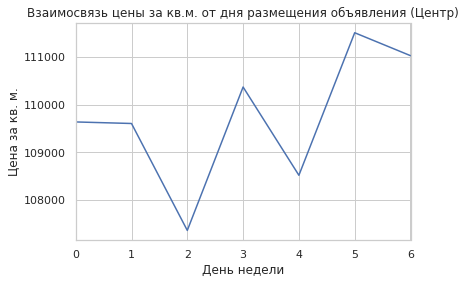

In [81]:
ax = spb_cen.groupby('weekday_pub')['avg_price'].median().plot()
ax.set(title = 'Взаимосвязь цены за кв.м. от дня размещения объявления (Центр)', xlabel =  "День недели", ylabel = 'Цена за кв. м.')


[Text(0, 0.5, 'Цена за кв. м.'),
 Text(0.5, 0, 'День недели'),
 Text(0.5, 1.0, 'Взаимосвязь цены за кв.м. от дня размещения объявления (Весь город)')]

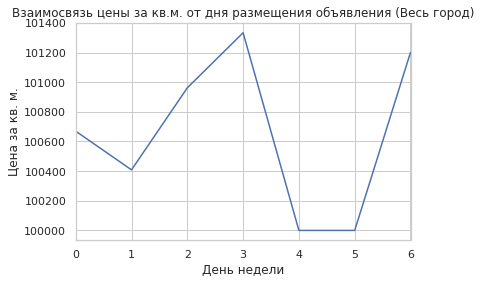

In [82]:
ax = spb.groupby('weekday_pub')['avg_price'].median().plot()
ax.set(title = 'Взаимосвязь цены за кв.м. от дня размещения объявления (Весь город)', xlabel =  "День недели", ylabel = 'Цена за кв. м.')

[Text(0, 0.5, 'Цена за кв. м.'),
 Text(0.5, 0, 'День недели'),
 Text(0.5, 1.0, 'Взаимосвязь цены за кв.м. от дня недели размещения объявления (Сравнение)')]

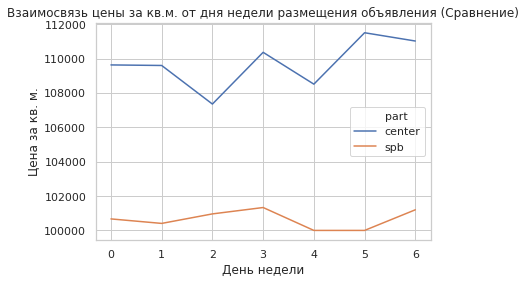

In [83]:
plot_comp_cen = spb_cen.groupby('weekday_pub')['avg_price'].median().round().reset_index()
plot_comp_cen['part'] = 'center'
plot_comp_cen.set_axis(['weekday','price','part'], axis = 'columns', inplace = True)

plot_comp_spb = spb.groupby('weekday_pub')['avg_price'].median().round().reset_index()
plot_comp_spb['part'] = 'spb'
plot_comp_spb.set_axis(['weekday','price','part'], axis = 'columns', inplace = True)

pivot_comp = pd.concat([plot_comp_cen,plot_comp_spb], ignore_index=False)

ax = sns.lineplot(x="weekday", y = 'price',  data=pivot_comp, hue="part")
ax.set(title = 'Взаимосвязь цены за кв.м. от дня недели размещения объявления (Сравнение)', xlabel =  "День недели", ylabel = 'Цена за кв. м.')

Сравним корреляции по центру и всему городу (влияние дня публикации на стоимость)

In [84]:
display(spb_cen['weekday_pub'].corr(spb_cen['avg_price']).round(3))
print('--vs--')
display(spb['weekday_pub'].corr(spb['avg_price']).round(3))

0.034

--vs--


-0.0

Узнаем, как влияет дата публикации на цену. Для начала проверим, достаточно ли данных по каждому месяцу, чтобы проводить анализ

In [85]:
spb_cen['month_pub'].value_counts()

2     188
11    182
4     177
10    173
3     171
9     167
6     162
7     141
12    138
8     138
1     116
5     100
Name: month_pub, dtype: int64

[Text(0, 0.5, 'Цена за кв. м.'),
 Text(0.5, 0, 'Месяц'),
 Text(0.5, 1.0, 'Взаимосвязь цены за кв.м. от месяца размещения объявления (Центр)')]

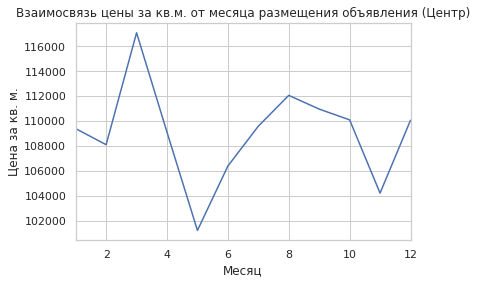

In [86]:
ax = spb_cen.groupby('month_pub')['avg_price'].median().plot( grid = True)
ax.set(title = 'Взаимосвязь цены за кв.м. от месяца размещения объявления (Центр)', xlabel =  "Месяц", ylabel = 'Цена за кв. м.')

[Text(0, 0.5, 'Цена за кв. м.'),
 Text(0.5, 0, 'Месяц'),
 Text(0.5, 1.0, 'Взаимосвязь цены за кв.м. от месяца размещения объявления (Весь город)')]

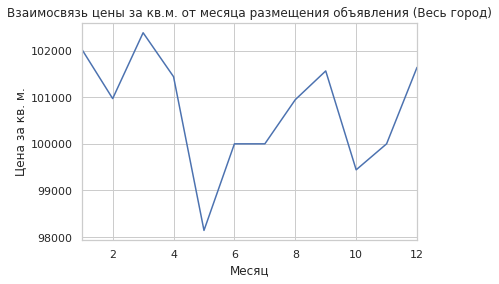

In [87]:
ax = spb.groupby('month_pub')['avg_price'].median().plot( grid = True)
ax.set(title = 'Взаимосвязь цены за кв.м. от месяца размещения объявления (Весь город)', xlabel =  "Месяц", ylabel = 'Цена за кв. м.')

[Text(0, 0.5, 'Цена за кв. м.'),
 Text(0.5, 0, 'Месяц'),
 Text(0.5, 1.0, 'Взаимосвязь цены за кв.м. от месяца размещения объявления (Сравнение)')]

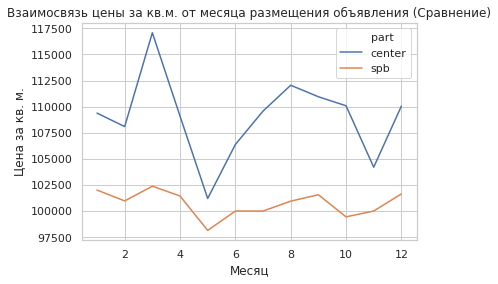

In [88]:
plot_comp_cen2 = spb_cen.groupby('month_pub')['avg_price'].median().round().reset_index()
plot_comp_cen2['part'] = 'center'
plot_comp_cen2.set_axis(['month','price','part'], axis = 'columns', inplace = True)

plot_comp_spb2 = spb.groupby('month_pub')['avg_price'].median().round().reset_index()
plot_comp_spb2['part'] = 'spb'
plot_comp_spb2.set_axis(['month','price','part'], axis = 'columns', inplace = True)

pivot_comp2 = pd.concat([plot_comp_cen2,plot_comp_spb2], ignore_index=False)

ax = sns.lineplot(x="month", y = 'price',  data=pivot_comp2, hue="part")
ax.set(title = 'Взаимосвязь цены за кв.м. от месяца размещения объявления (Сравнение)', xlabel =  "Месяц", ylabel = 'Цена за кв. м.')

Сравним корреляции по центру и всему городу (влияние месяца публикации на стоимость)


In [89]:
display(spb_cen['month_pub'].corr(spb_cen['avg_price']).round(3))
print('--vs--')
display(spb['month_pub'].corr(spb['avg_price']).round(3))

-0.022

--vs--


-0.02

В целом, картина по городу и в центре похожа, однако может видеть рост цен к новогодним праздникам в целом по городу, возможно, это связано с тем, что банки активнее выдают ипотеку под новостройки, которые находятся не в центре. Предполагаю, что все сэкономленные деньги, годовые бонусы или своего рода "подарки на Новый Год" уходят на покупку недвижимости за центром. Опять же можем наблюдать снижение активности в начале лета.

In [90]:
month_corr = flats.groupby('month_pub')['avg_price'].median().round().reset_index()
display(round(month_corr['month_pub'].corr(month_corr['avg_price']), 3))
print('--vs--')
display(round(flats['month_pub'].corr(flats['avg_price']), 3))

-0.187

--vs--


-0.003

### Шаг 5. Общий вывод

**Среднее объявление:**
 - Метраж квартиры 52 квадратных метра
 - Высота потолков 2,65 метра
 - Стоимость за квадратный метр  95 тыс.ед.
 - Количество комнат 2


**Параметры влияющие на цену недвижимости: (По степени влияния)** 


**1) Ставка по ипотеке**

На графике зависимости средней цены от года, мы прекрасно видим, как менялась цена вслед за ключевой ставкой ЦБ.

**2) Населенный пункт**

Цена напрямую зависит от от населенного пункта. Самые дорогие квартиры в городах, которые находятся в предалах или непосредственной близости КАД.

Пять самых дорогих городов: 
- 1 санкт-петербург	(105 т. за кв.м)
- 2	пушкино (100 т. за кв.м)
- 3	кудрово	(95 т. за кв.м)
- 4	парголово (92 т. за кв.м)	 
- 5	мурино	(86 т. за кв.м)

**3) Расстояние от центра**

Предмет анализа - Санкт-Петербург:

Так на долю СПб приходится 67% объявлений, а у ближайшего приследователя только 2,5% то следующие выводы будет интересно сделать именно по Санкт-Петербургу

На стоимость квартиры сильно влияет расстояние от центра города, очевидно, что самые дорогие квартиры находятся в историческом центре до 3км, где ценовой диапазон от 120 до 170 тыс. за кв. м. при средней цене 105. Так же имеется небольшой пик средней от 4 до 8 км с ценой около 120-130 т. за кв. метр. Люди предпочитают жить немного дальше, но в новых домах, нежели на окрайне исторического центра, но в старых.


**4) Общая площадь**

Предмет анализа - Санкт-Петербург, центр:

Для анализа менее значимых факторов возьмем только центральную зону (в пределах 8км. от центра) Санкт-Петербурга.

После проведенной работы: анализа корреляции и построения диаграмм рассеяния, мы можем сделать вывод, что площадь недвижимости обратно пропорциональна средней стоимости квадратного метра. Корреляция не сильная, но есть (29%).
Чем больше площадь - меньше цена кв. метра. 


**5) Число комнат**

Предмет анализа - Санкт-Петербург, центр, более шести комнат.

Так как количество публикаций с количеством комнат более 6 крайне мало, мы не можем включить их в выборку, чтобы не искажать средние меры.

На графике в главе, где мы изучали факторы влияющие на цену хорошо видно, насколько очевидна обратная зависимость между количеством комнат и ценой.

однокомнатная квартира в центре Санкт-Петербурга в среднем обойдется вам в 138 т. за кв. м., в то время, как шестикомнатная уже 103 т. за кв.м.

**6) Прочие факторы влияющие на цену**

**Этаж**

Люди препочитают жить на любой этаже кроме последнего и особенного первого
Стоимость жилья на первом и последнем этаже - ниже средней ( 81 и 87 т.), в то время как жилья на остальных этажах выше средней - 98 т.р.


**Месяц подачи объявления**

Средняя цена за квадратный метр объявлений в начале лета проседает до 93 т., в то время, как в начале года цена может достигать 97 т.

**День подачи объявления**

Похожая картина и с днем подачи объявления, на графиках можем наблиюдать что на обявления поданые на выходных обычно имеют меньшую стооимость за кв. м. около 93,5 т. А на буднях цена достагает 96,5 т. Возможно, это связано с тем, что владельцы более дорогих квартир работают с агествами, которые публикуют обьявления за них, в том время, как владельцы более дешевого жилья делают это в свободное время (на выходных) 
